In [1]:
%load_ext lab_black

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import os
import re

# Checking the quality and predictive power of WHO Data on COVID-19

# Business Understanding
The WHO - the public health agency of the UN - has the goal to achiev the attainment of the highest possible level of health for everyone. During a pandemic, this mission becomes particularly important and difficult since the high communicability and the potentially severe course of COVID-19 imposes a large burden on people and their health system independent of any borders.

To mitigate the effects of disease outbreaks, the WHO monitors public health risks and coordinates responses to health emergencies. WHO's actions depends on their collected data. [This dashboard](https://covid19.who.int/) is one of WHOs publically available information on COVID.

## Questions
- How good is the data used by the WHO?
- Are high incidences spatially bound (i.e., stay within a region)?
- Are epidemiological assessments increasing the performance of a machine-learning model additional to raw data? 

## Data Preparation

The data was scraped using `scheduler.py`. Its mechanic is described in `scrape.ipynb`. We read in all scraped data which are a snapshot of [WHO's dashboard on COVID-19 infections](https://covid19.who.int/) and concate them to a dataframe that also functions as a timeseries.

In [3]:
tables = os.listdir("scraped/")
timeseries = pd.concat(
    [
        pd.read_csv("scraped/" + file_).assign(
            date=re.match(r"\D+(\d{4}-\d{2}-\d{2}).+", file_)[1]
        )
        for file_ in tables
    ]
)

In [4]:
timeseries.tail()

,WHO_Name,WHO_Region,Cases - cumulative total,Cases - cumulative total per 1 million population,Cases - newly reported in last 7 days,Cases - newly reported in last 24 hours,Deaths - cumulative total,Deaths - cumulative total per 1 million population,Deaths - newly reported in last 7 days,Deaths - newly reported in last 24 hours,Transmission Classification,date
233,Saint Helena,Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
234,Tokelau,Western Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
235,Tonga,Western Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
236,Turkmenistan,Europe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
237,Tuvalu,Western Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30


### Question 1: How good is the data used by the WHO?
In the following I will try to answer the consistancy of the data set and the reporting behavior.

#### Missing data
Generally, missing data in this dataset is seldom. There is no variable that has over 1% missing data. But is the data really this good?

In [5]:
timeseries.isna().sum() / timeseries.shape[0] * 100

WHO_Name                                              0.000000
WHO_Region                                            0.637245
Cases - cumulative total                              0.216934
Cases - cumulative total per 1 million population     0.637245
Cases - newly reported in last 7 days                 0.216934
Cases - newly reported in last 24 hours               0.216934
Deaths - cumulative total                             0.216934
Deaths - cumulative total per 1 million population    0.637245
Deaths - newly reported in last 7 days                0.216934
Deaths - newly reported in last 24 hours              0.216934
Transmission Classification                           0.637245
date                                                  0.000000
dtype: float64

#### Consitancy
Let's check the cumulative counts. Per definition, these numbers cannot decrease. So a value from one day to the other is either larger or equally large. How many entries in this data set satisfy this criterion?

In [6]:
def create_diff(timespan):
    return (
        timeseries.sort_values(by=["WHO_Name", "date"])
        .set_index(["WHO_Name", "date"])
        .groupby("WHO_Name")[["Cases - cumulative total", "Deaths - cumulative total"]]
        .diff(timespan)
    )

In [7]:
diff_one = create_diff(1)

print(
    round(
        len(diff_one[diff_one["Cases - cumulative total"] < 0]) / len(diff_one) * 100,
        ndigits=2,
    ),
    "% of the cumulative cases decrease from one day to the other",
)

print(
    round(
        len(diff_one[diff_one["Deaths - cumulative total"] < 0]) / len(diff_one) * 100,
        ndigits=2,
    ),
    "% of the cumulative deaths decrease from one day to the other",
)

0.09 % of the cumulative cases decrease from one day to the other
0.06 % of the cumulative deaths decrease from one day to the other


How about their information on `Cases/Deaths - newly reported in last 7 days`. This should be the same as if taking the difference between the cumulative death and case counts from 7 days ago.

In [8]:
diff_seven = create_diff(7)

In [9]:
diffs_expected = (
    timeseries.sort_values(by=["WHO_Name", "date"])
    .set_index(["WHO_Name", "date"])
    .loc[
        :,
        [
            "Deaths - newly reported in last 7 days",
            "Cases - newly reported in last 7 days",
        ],
    ]
)

In [10]:
merged = diff_seven.merge(diffs_expected, left_index=True, right_index=True).dropna()

In [11]:
print(
    round(
        (
            merged["Cases - cumulative total"]
            == merged["Cases - newly reported in last 7 days"]
        ).sum()
        / len(merged)
        * 100,
        ndigits=2,
    ),
    "% of the difference taken from the cumulative case count from 7 days ago match up with the column of newly reported deaths",
)

print(
    round(
        (
            merged["Deaths - cumulative total"]
            == merged["Deaths - newly reported in last 7 days"]
        ).sum()
        / len(merged)
        * 100,
        ndigits=2,
    ),
    "% of the difference taken from the cumulative deaths count from 7 days ago match up with the column of newly reported deaths",
)

83.19 % of the difference taken from the cumulative case count from 7 days ago match up with the column of newly reported deaths
88.23 % of the difference taken from the cumulative deaths count from 7 days ago match up with the column of newly reported deaths


#### Reporting behavior
Within which time span are countries reporting new cases

In [12]:
unchanged_cases = []
unchanged_deaths = []
for i in range(0, 30):
    diff_df = create_diff(i)
    unchanged_cases.append(
        round(
            len(diff_df[diff_df["Cases - cumulative total"] != 0]) / len(diff_df) * 100,
            ndigits=2,
        )
    )
    unchanged_deaths.append(
        round(
            len(diff_df[diff_df["Deaths - cumulative total"] != 0])
            / len(diff_df)
            * 100,
            ndigits=2,
        )
    )

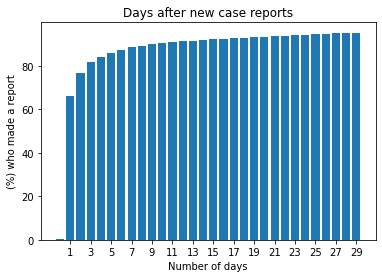

In [13]:
plt.bar(range(0, 30), unchanged_cases)
plt.title("Days after new case reports")
plt.xlabel("Number of days")
plt.xticks(range(1, 30, 2))
plt.ylabel("(%) who made a report")
plt.show()

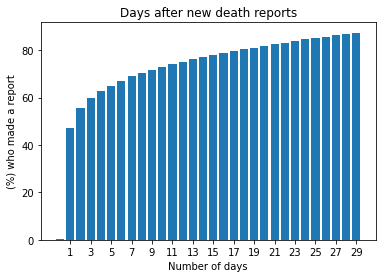

In [14]:
plt.bar(range(0, 30), unchanged_deaths)
plt.title("Days after new death reports")
plt.xlabel("Number of days")
plt.xticks(range(1, 30, 2))
plt.ylabel("(%) who made a report")
plt.show()

We can see that most cases and deaths (16.04% and 15.84% respectively) are reported on a Monday and the least on Sunday (13.72% of the cases and 13.79% of the deaths). This could explain why not the strong manjority reports new numbers every day besides not having anything to report: There is a reporting gap during the weekend.

In [32]:
week_day_statistic = (
    timeseries.assign(
        day_name=lambda x: x.date.apply(lambda y: pd.to_datetime(y).day_name())
    )
    .sort_values(by=["WHO_Name", "date"])
    .set_index(["WHO_Name", "date", "day_name"])
    .groupby(["WHO_Name", "day_name"])[
        ["Cases - cumulative total", "Deaths - cumulative total"]
    ]
    .diff(1)
    .groupby("day_name")
    .mean()
)

In [39]:
round(week_day_statistic / week_day_statistic.sum() * 100, ndigits=2)

,Cases - cumulative total,Deaths - cumulative total
day_name,,
Friday,14.04,14.16
Monday,16.04,15.84
Saturday,13.98,14.19
Sunday,13.72,13.79
Thursday,14.07,14.10
Tuesday,14.08,13.93
Wednesday,14.07,14.00
